In [ ]:
#%matplotlib inline

import torch
import random


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị sử dụng: {device}")

Thiết bị sử dụng: cpu


In [59]:
BATCH_SIZE = 64
LATENT_DIM = 100    
LEARNING_RATE = 0.0002 
NUM_EPOCHS = 100


In [39]:
df = pd.read_csv('all_landmarks.csv')
df.head()

,label,frame,x0,y0,x1,y1,x2,y2,x3,y3,...,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20
0,thumb,0,0.599915,0.665262,0.515953,0.665098,0.428840,0.633735,0.373814,0.601213,...,0.564590,0.550839,0.594947,0.469473,0.579057,0.432039,0.587348,0.481080,0.593778,0.516935
1,thumb,1,0.603023,0.697286,0.507298,0.672530,0.430429,0.638797,0.374489,0.601450,...,0.563151,0.544787,0.603814,0.477666,0.586528,0.427248,0.588528,0.476918,0.594982,0.515491
2,thumb,2,0.578484,0.664635,0.484652,0.639102,0.405413,0.603161,0.334007,0.565351,...,0.531455,0.492580,0.565373,0.441291,0.561908,0.379894,0.566244,0.439990,0.565475,0.475714
3,thumb,3,0.581487,0.675659,0.482386,0.638060,0.405132,0.608401,0.334031,0.565769,...,0.531379,0.501897,0.565993,0.438266,0.559864,0.379514,0.561746,0.442510,0.562781,0.481083
4,thumb,4,0.551713,0.643821,0.452903,0.613882,0.370420,0.581506,0.294350,0.545547,...,0.499876,0.477000,0.539230,0.416825,0.530130,0.364053,0.533174,0.430488,0.532756,0.462243


In [40]:
df = df.drop(columns=['frame'])
df.columns

Index(['label', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4',
       'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10',
       'y10', 'x11', 'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15',
       'y15', 'x16', 'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20',
       'y20'],
      dtype='object')

In [55]:
NUM_CLASSES = df['label'].nunique()
print(f"Số lượng lớp (nhãn dán): {NUM_CLASSES}")

Số lượng lớp (nhãn dán): 2


In [43]:
class CoordinateDataset(Dataset):
    def __init__(self, df):
        """
        Khởi tạo dataset từ file CSV.
        Args:
            csv_file (str): Đường dẫn đến file CSV chứa tọa độ và nhãn dán.
        """
        self.data = df
        
        # Lấy nhãn dán
        self.labels = self.data['label'].values.reshape(-1, 1)

        # Sử dụng LabelEncoder và OneHotEncoder
        # 1. Label Encoding: Chuyển đổi nhãn chữ thành số
        le = LabelEncoder()
        integer_encoded = le.fit_transform(self.labels.ravel())
        
        # 2. One-Hot Encoding: Chuyển đổi số thành vector nhị phân
        onehot_encoder = OneHotEncoder(sparse_output=False)
        self.onehot_labels = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

        # Lưu thông tin về các nhãn
        self.num_classes = self.onehot_labels.shape[1]
        self.label_to_int = {label: i for i, label in enumerate(le.classes_)}
        self.int_to_label = {i: label for i, label in enumerate(le.classes_)}

        # Lấy dữ liệu tọa độ
        self.coordinates = self.data.drop('label', axis=1).values.astype(np.float32)

        # Lưu lại min/max của tọa độ để khôi phục sau này
        self.coordinates_min = self.coordinates.min(axis=0)
        self.coordinates_max = self.coordinates.max(axis=0)

        # Chuẩn hóa dữ liệu tọa độ về khoảng [-1, 1]
        self.coordinates = 2 * (self.coordinates - self.coordinates_min) / (self.coordinates_max - self.coordinates_min) - 1

    def __len__(self):
        """
        Trả về số lượng mẫu trong dataset.
        """
        return len(self.coordinates)

    def __getitem__(self, idx):
        """
        Lấy một mẫu dữ liệu và nhãn dán tại chỉ số idx.
        """
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        onehot_label = torch.tensor(self.onehot_labels[idx], dtype=torch.float32)
        return coordinates, onehot_label

In [51]:
# Đổi thành đường dẫn tới file CSV của bạn
dataset = CoordinateDataset(df)
dataloader = DataLoader(dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

# Lấy số lượng đặc trưng từ dữ liệu
NUM_FEARTURES = len(dataset[0][0])
print(f"Số lượng đặc trưng (điểm tọa độ): {NUM_FEARTURES}")

Số lượng đặc trưng (điểm tọa độ): 42


In [67]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_features, num_classes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Lớp đầu vào nhận cả latent_dim và num_classes
        self.main = nn.Sequential(
            nn.Linear(self.latent_dim + self.num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_features),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        # Nối vector nhiễu (z) và vector nhãn (labels)
        conditional_input = torch.cat([z, labels], 1)
        return self.main(conditional_input)

In [69]:
class Discriminator(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes

        # Lớp đầu vào nhận cả num_features và num_classes
        self.main = nn.Sequential(
            nn.Linear(num_features + self.num_classes, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Nối dữ liệu (x) và vector nhãn (labels)
        conditional_input = torch.cat([x, labels], 1)
        return self.main(conditional_input)

In [71]:
# Khởi tạo các mô hình và chuyển sang device
generator = Generator(LATENT_DIM, NUM_FEARTURES, NUM_CLASSES).to(device)
discriminator = Discriminator(NUM_FEARTURES, NUM_CLASSES).to(device)

In [74]:
for epoch in range(NUM_EPOCHS):
    for i, (real_data, real_labels_one_hot) in enumerate(dataloader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)
        real_labels_one_hot = real_labels_one_hot.to(device)


        # Tạo nhãn thật và giả  
        real_labels = torch.ones(batch_size, 1).to(device)  
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # ========================
        #  Train Discriminator
        # ========================
        discriminator.zero_grad()
        # Đánh giá dữ liệu thật với nhãn thật   
        outputs = discriminator(real_data, real_labels_one_hot) 
        d_loss_real = nn.BCELoss()(outputs, real_labels)
        d_loss_real.backward()
        D_x = outputs.mean().item()
        
        # Tạo dữ liệu giả   
        noise = torch.randn(batch_size, LATENT_DIM).to(device)  
        random_labels = torch.randint(0, NUM_CLASSES, (batch_size,)).to(device) 
        random_labels_one_hot = torch.zeros(batch_size, NUM_CLASSES).to(device)
        random_labels_one_hot.scatter_(1, random_labels.view(-1, 1), 1) 
        fake_data = generator(noise, random_labels_one_hot) 
        # Đánh giá dữ liệu giả với nhãn giả 
        outputs = discriminator(fake_data.detach(), random_labels_one_hot)
        d_loss_fake = nn.BCELoss()(outputs, fake_labels)
        d_loss_fake.backward()
        D_G_z1 = outputs.mean().item()
        d_loss = d_loss_real + d_loss_fake
        # Cập nhật trọng số của Discriminator   
        optimizerD = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))   
        optimizerD.step()
        # ========================  
        #  Train Generator  
        # ========================  
        generator.zero_grad()   
        # Tạo dữ liệu giả mới   
        noise = torch.randn(batch_size, LATENT_DIM).to(device)  
        random_labels = torch.randint(0, NUM_CLASSES, (batch_size,)).to(device) 
        random_labels_one_hot = torch.zeros(batch_size, NUM_CLASSES).to(device) 
        random_labels_one_hot.scatter_(1, random_labels.view(-1, 1), 1) 
        fake_data = generator(noise, random_labels_one_hot) 
        # Đánh giá dữ liệu giả với nhãn thật (muốn đánh lừa Discriminator)  
        outputs = discriminator(fake_data, random_labels_one_hot)   
        g_loss = nn.BCELoss()(outputs, real_labels) 
        g_loss.backward()   
        D_G_z2 = outputs.mean().item()  
        # Cập nhật trọng số của Generator   
        optimizerG = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))   
        optimizerG.step()   
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item():.4f}, loss G: {g_loss.item():.4f} \
                  D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")   

Epoch [1/100] Batch 0/157                   Loss D: 1.3841, loss G: 0.6980                   D(x): 0.4995, D(G(z)): 0.4984 / 0.4976
Epoch [1/100] Batch 50/157                   Loss D: 0.8271, loss G: 1.5367                   D(x): 0.7442, D(G(z)): 0.3742 / 0.2177
Epoch [1/100] Batch 100/157                   Loss D: 1.9246, loss G: 1.0798                   D(x): 0.5591, D(G(z)): 0.6876 / 0.3476
Epoch [1/100] Batch 150/157                   Loss D: 0.8141, loss G: 1.9995                   D(x): 0.6296, D(G(z)): 0.2647 / 0.1362
Epoch [2/100] Batch 0/157                   Loss D: 0.5634, loss G: 2.3775                   D(x): 0.7360, D(G(z)): 0.2055 / 0.0940
Epoch [2/100] Batch 50/157                   Loss D: 0.2966, loss G: 2.6274                   D(x): 0.8779, D(G(z)): 0.1420 / 0.0730
Epoch [2/100] Batch 100/157                   Loss D: 0.5631, loss G: 2.8197                   D(x): 0.8164, D(G(z)): 0.2551 / 0.0660
Epoch [2/100] Batch 150/157                   Loss D: 0.6976, loss G

In [ ]:
fake_data_with_labels = {}
data = []
# Lặp qua từng nhãn dán có trong dataset gốc
num_samples_per_label = 5  # Số mẫu muốn tạo cho mỗi nhãn
for label, label_int in dataset.label_to_int.items():
    print(f"\nĐang tạo {num_samples_per_label} mẫu cho nhãn: '{label}' (int: {label_int})")
    
    # 1. Tạo vector nhãn dán ở dạng one-hot
    # Tạo tensor nhãn integer
    target_label_int_tensor = torch.full((num_samples_per_label,), label_int, dtype=torch.long, device=device)
    # Chuyển đổi thành one-hot encoding
    target_labels_one_hot = torch.nn.functional.one_hot(target_label_int_tensor, num_classes=NUM_CLASSES    ).float().to(device)

    # 2. Tạo vector nhiễu ngẫu nhiên
    noise = torch.randn(num_samples_per_label, LATENT_DIM   , device=device)

    # 3. Sử dụng Generator để tạo dữ liệu giả
    with torch.no_grad():
        fake_coords_normalized = generator(noise, target_labels_one_hot).cpu().numpy()

    # 4. Khôi phục tọa độ về tỷ lệ gốc
    fake_coords_original_scale = (fake_coords_normalized + 1) / 2 * (dataset.coordinates_max - dataset.coordinates_min) + dataset.coordinates_min

    # 5. Lưu dữ liệu giả và nhãn tương ứng vào dictionary
    # Lặp lại nhãn để khớp với số lượng mẫu đã tạo
    fake_labels_np = np.full((num_samples_per_label, 1), label)
    
    # Kết hợp tọa độ giả và nhãn giả
    combined_data = np.hstack((fake_coords_original_scale, fake_labels_np))
    
    fake_data_with_labels[label] = combined_data


Đang tạo 5 mẫu cho nhãn: 'index' (int: 0)

Đang tạo 5 mẫu cho nhãn: 'thumb' (int: 1)


(5, 22) (5, 21)


ValueError: x and y must be the same size

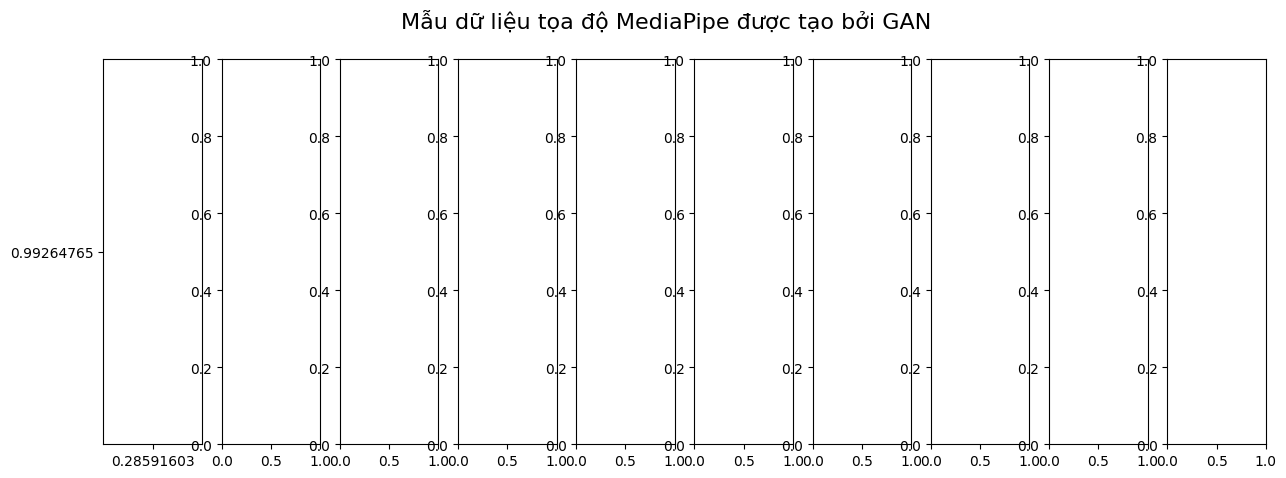

In [104]:


# Giả định dữ liệu là 21 điểm của bàn tay (42 tọa độ)
num_landmarks = 42 // 2

# Định nghĩa các kết nối giữa các điểm để vẽ đường nối
# Dựa trên cấu trúc bàn tay của MediaPipe Hand Landmarks
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),      # Ngón cái
    (0, 5), (5, 6), (6, 7), (7, 8),      # Ngón trỏ
    (5, 9), (9, 10), (10, 11), (11, 12), # Ngón giữa
    (9, 13), (13, 14), (14, 15), (15, 16), # Ngón áp út
    (13, 17), (17, 18), (18, 19), (19, 20), # Ngón út
    (0, 17) # Nối ngón cái và ngón út
]

# Tạo một figure và các subplot để hiển thị 5 mẫu
fig, axes = plt.subplots(1, num_samples_per_label*NUM_CLASSES, figsize=(15, 5))
fig.suptitle('Mẫu dữ liệu tọa độ MediaPipe được tạo bởi GAN', fontsize=16)
for key, value in fake_data_with_labels.items():
    x_coords = value[:, 0::2]  # Tọa độ x   
    y_coords = value[:, 1::2]  # Tọa độ y
    item = value[0]
    print(x_coords.shape, y_coords.shape)   
    
    for i in range(num_samples_per_label):  
        ax = axes[i]
        
        # Vẽ các điểm mốc (landmarks)
        ax.scatter(x_coords[i], y_coords[i], color='blue', s=20, zorder=5)

        # Vẽ các đường nối giữa các điểm
        for start, end in connections:
            ax.plot([x_coords[i][start], x_coords[i][end]], 
                    [y_coords[i][start], y_coords[i][end]], 
                    color='green', linewidth=2, zorder=1)

        # Đặt giới hạn cho trục để hình ảnh không bị méo
        # Matplotlib có thể tự động điều chỉnh giới hạn, nhưng việc đặt thủ công giúp các subplot đồng nhất
        ax.set_xlim(dataset.coordinates_min[0::2].min(), dataset.coordinates_max[0::2].max())
        ax.set_ylim(dataset.coordinates_min[1::2].min(), dataset.coordinates_max[1::2].max())

        # Đảo ngược trục y để gốc tọa độ ở trên cùng, giống với hình ảnh thông thường
        ax.invert_yaxis()
        ax.set_title(f'Mẫu {i+1} - Nhãn: {item[0]}')
        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# for i in range(num_samples_per_label):
#     # Trích xuất tọa độ x, y cho mẫu thứ i
#     x_coords = data[i][i, 0::2]
#     y_coords = data[i][i, 1::2]
#     print (x_coords)
#     print("/")
#     print (y_coords)    
    
#     ax = axes[i]
    
#     # Vẽ các điểm mốc (landmarks)
#     ax.scatter(x_coords, y_coords, color='blue', s=20, zorder=5)

#     # Vẽ các đường nối giữa các điểm
#     for start, end in connections:
#         ax.plot([x_coords[start], x_coords[end]], 
#                 [y_coords[start], y_coords[end]], 
#                 color='green', linewidth=2, zorder=1)

#     # Đặt giới hạn cho trục để hình ảnh không bị méo
#     # Matplotlib có thể tự động điều chỉnh giới hạn, nhưng việc đặt thủ công giúp các subplot đồng nhất
#     ax.set_xlim(dataset.coordinates_min[0::2].min(), dataset.coordinates_max[0::2].max())
#     ax.set_ylim(dataset.coordinates_min[1::2].min(), dataset.coordinates_max[1::2].max())

#     # Đảo ngược trục y để gốc tọa độ ở trên cùng, giống với hình ảnh thông thường
#     ax.invert_yaxis()
#     ax.set_title(f'Mẫu {i+1}')
#     ax.set_aspect('equal', adjustable='box') # Đảm bảo tỷ lệ x/y đồng nhất

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()